Here I showed a shortcoming of the method, and how to tackle it manually.

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots

In [2]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
def load(focus_class):
    with open(f'clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           feature_precisions=feature_precisions, state=state)
    return node

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 301it [00:19,  9.23it/s]                         
Exact explainer: 301it [00:13,  5.66it/s]                         


CPU times: user 31.8 s, sys: 292 ms, total: 32.1 s
Wall time: 33.4 s


In [7]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 11min 42s, sys: 6.4 s, total: 11min 49s
Wall time: 13min 7s


# Traditional SHAP Explanations

In [6]:
with open('indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [7]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

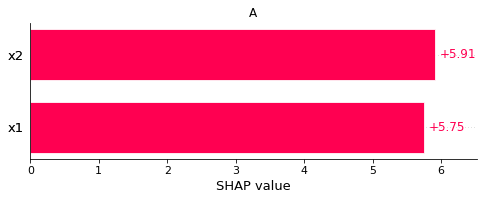

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

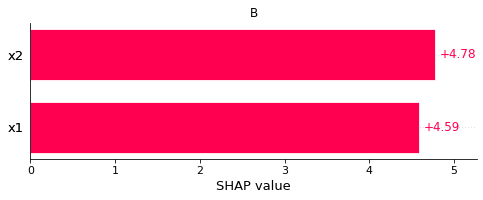

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 1.4 s, sys: 25.3 ms, total: 1.43 s
Wall time: 1.48 s


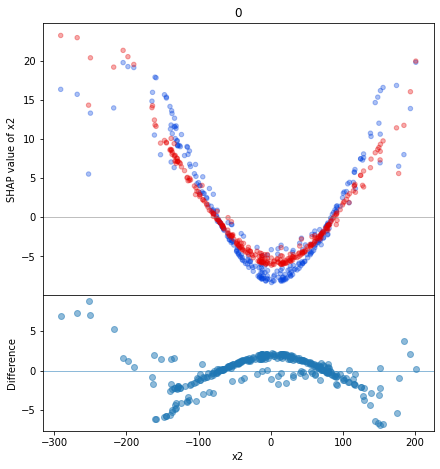

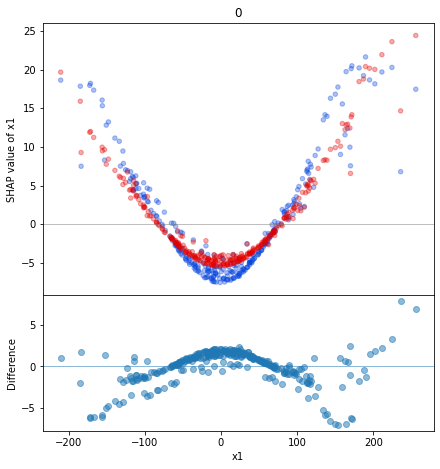

In [11]:
compare_indiv_dep_plots(node)

# Difference Classifier SHAP Explanations

In [13]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

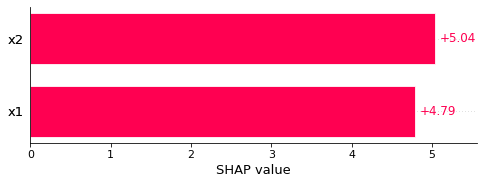

In [14]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## Clustering of Class $(1, 0)$ SHAP Values

In [15]:
node = load('(1, 0)')
node.distance, node.class_counts

(5281.429303669299,
 (0, 0)    150
 (1, 1)     95
 (1, 0)     55
 dtype: int64)

### Main Node (R)

In [16]:
node = node.root.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(R,
 (0, 0)    150
 (1, 1)     55
 (1, 0)     55
 dtype: int64,
 3691.2104115506604)

-128.05550895819533 <= x1 <= 127.60981964815691
[Lower CF: x1 == -143.8 --> {'(1, 1)': 55},
 Upper CF: x1 == 132.4 --> {'(1, 1)': 55}]


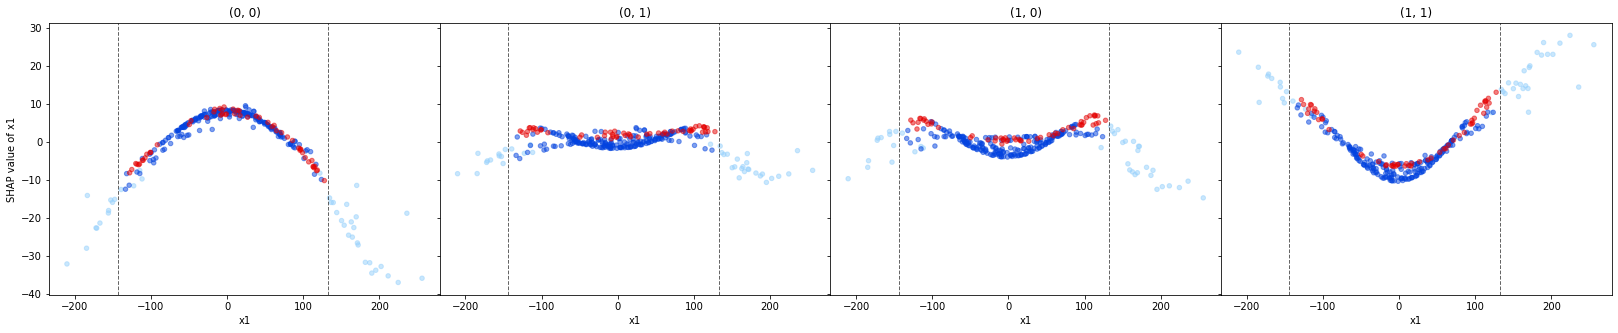

-129.7526473921083 <= x2 <= 128.64005345149593
[Lower CF: x2 == -131.2 --> {'(1, 1)': 55},
 Upper CF: x2 == 136.3 --> {'(1, 1)': 55}]


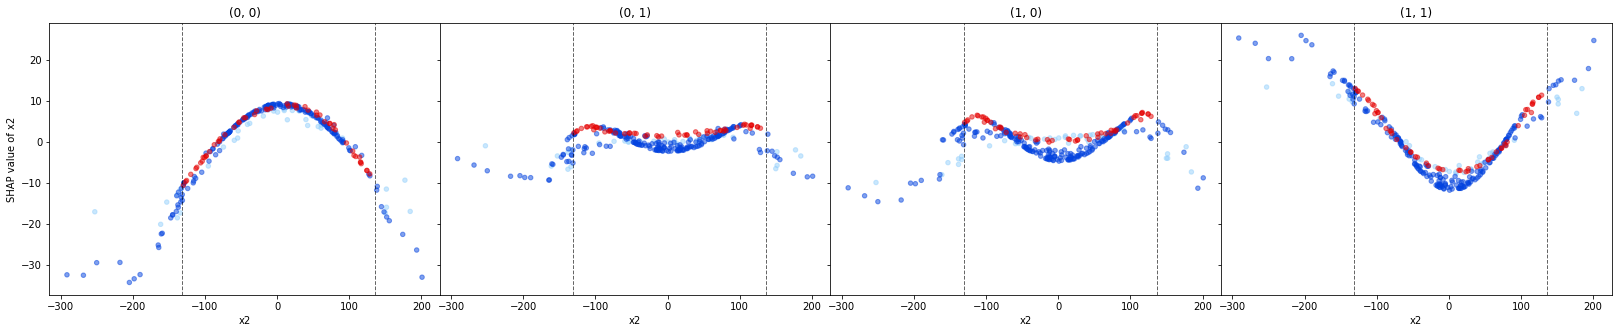

In [17]:
node.root.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

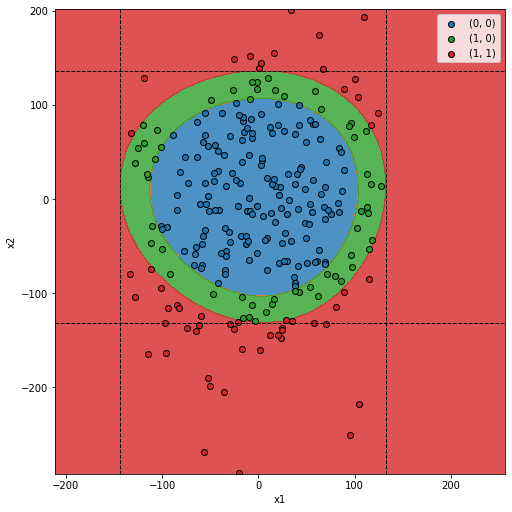

In [18]:
plot_2d_with_boundaries(node)

### Node 1 (RLR)

In [29]:
path = [node]
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLR,
 (0, 0)    40
 (1, 0)    32
 (1, 1)    17
 dtype: int64,
 847.9838472548745)

-128.05550895819533 <= x1 <= 127.60981964815691
[Lower CF: x1 == -143.8 --> {'(1, 1)': 55},
 Upper CF: x1 == 132.4 --> {'(1, 1)': 55}]


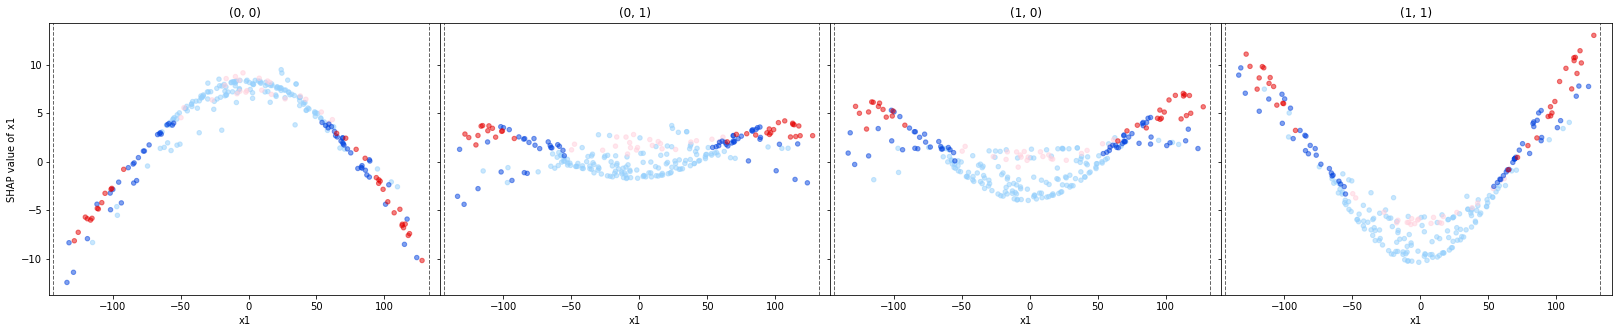

-129.7526473921083 <= x2 <= 128.64005345149593
[Lower CF: x2 == -131.2 --> {'(1, 1)': 55},
 Upper CF: x2 == 136.3 --> {'(1, 1)': 55}]


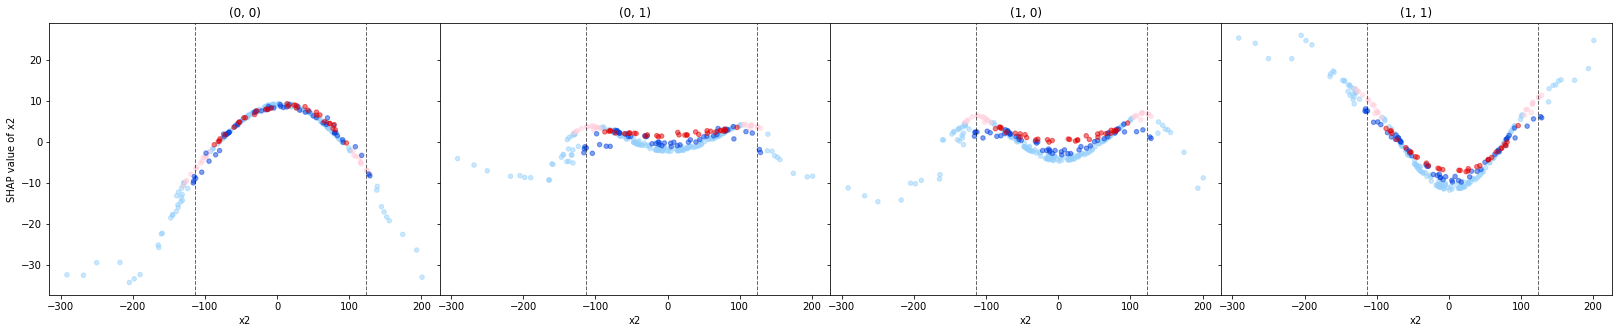

In [20]:
path[-1].plot_feature_dependence(*feature_names, focus=node, print_stats=True)

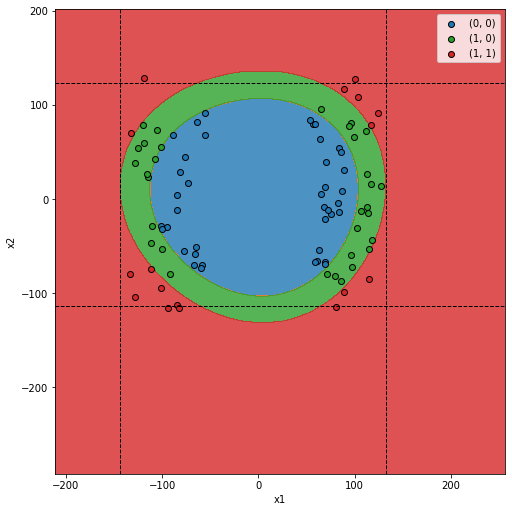

In [21]:
plot_2d_with_boundaries(node)

### Node 1.1

In [31]:
left = node.filter('x1 < 0')
node.class_counts

(0, 0)    40
(1, 0)    32
(1, 1)    17
dtype: int64

-128.05550895819533 <= x1 <= 127.60981964815691
[Lower CF: x1 == -143.8 --> {'(1, 1)': 32},
 Upper CF: x1 == 132.4 --> {'(1, 1)': 32}]


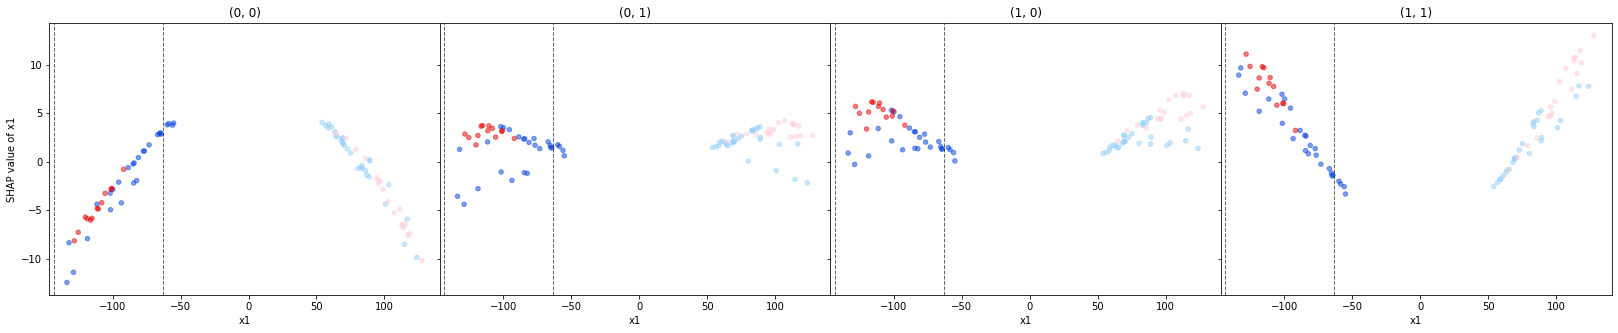

-86.97608572540292 <= x2 <= 96.21911955550605
[Lower CF: x2 == -113.6 --> {'(1, 1)': 32},
 Upper CF: x2 == 123.4 --> {'(1, 1)': 32}]


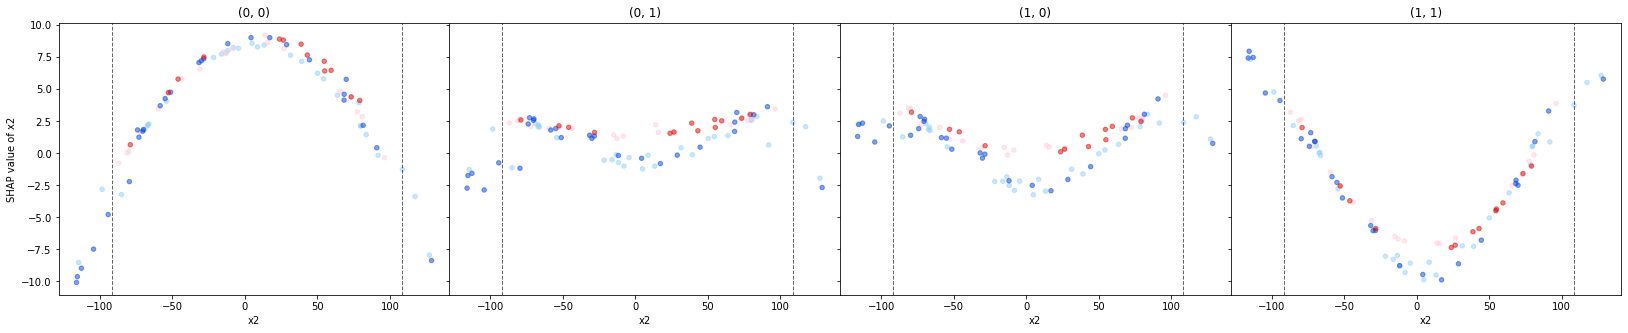

In [34]:
node.plot_feature_dependence(*feature_names, focus=left, print_stats=True)

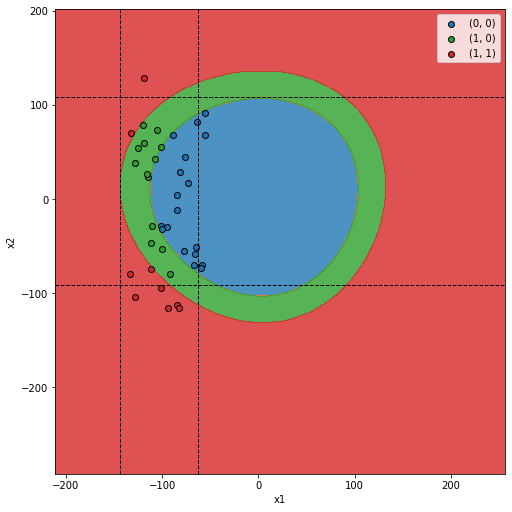

In [35]:
plot_2d_with_boundaries(left)

### Node 1.2

In [52]:
right = node.filter('x1 >= 0')
node.class_counts

(0, 0)    40
(1, 0)    32
(1, 1)    17
dtype: int64

-128.05550895819533 <= x1 <= 127.60981964815691
[Lower CF: x1 == -143.8 --> {'(1, 1)': 32},
 Upper CF: x1 == 132.4 --> {'(1, 1)': 32}]


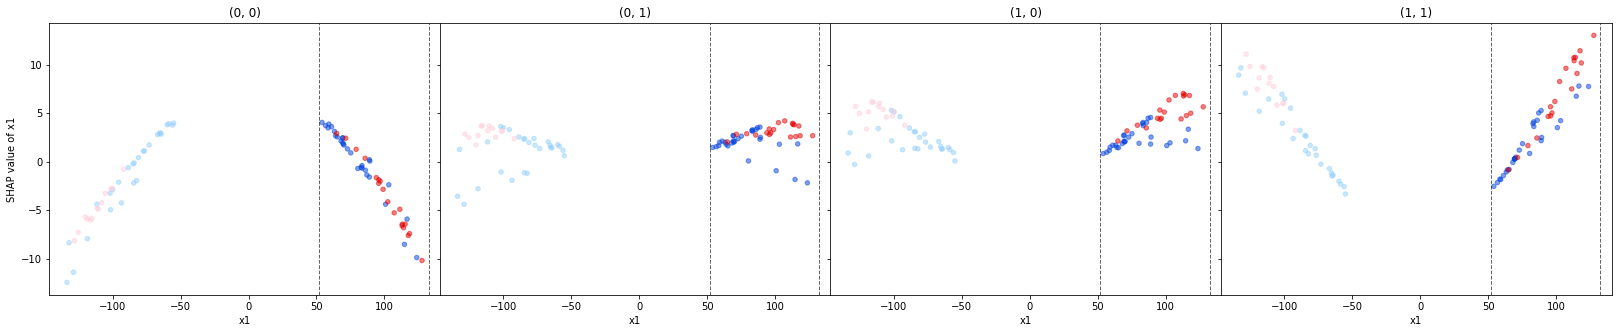

-86.97608572540292 <= x2 <= 96.21911955550605
[Lower CF: x2 == -113.6 --> {'(1, 1)': 32},
 Upper CF: x2 == 123.4 --> {'(1, 1)': 32}]


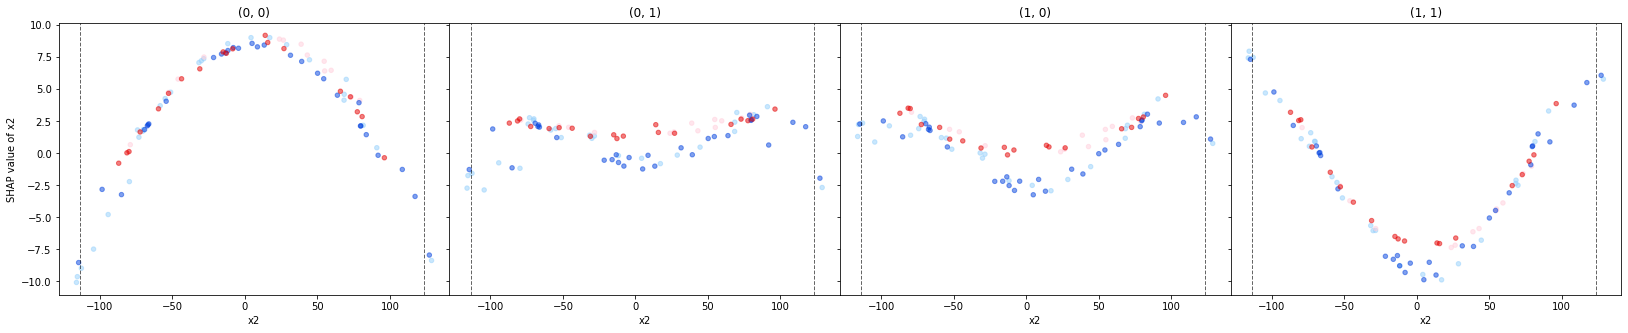

In [53]:
node.plot_feature_dependence(*feature_names, focus=right, print_stats=True)

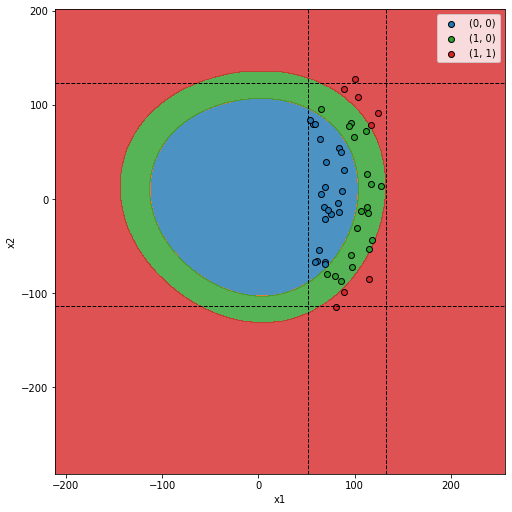

In [39]:
plot_2d_with_boundaries(right)

### Node 2 (RRRL)

In [41]:
node = path[-1].right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRRL,
 (1, 0)    23
 (1, 1)     8
 (0, 0)     6
 dtype: int64,
 248.90278427373778)

-128.05550895819533 <= x1 <= 127.60981964815691
[Lower CF: x1 == -143.8 --> {'(1, 1)': 55},
 Upper CF: x1 == 132.4 --> {'(1, 1)': 55}]


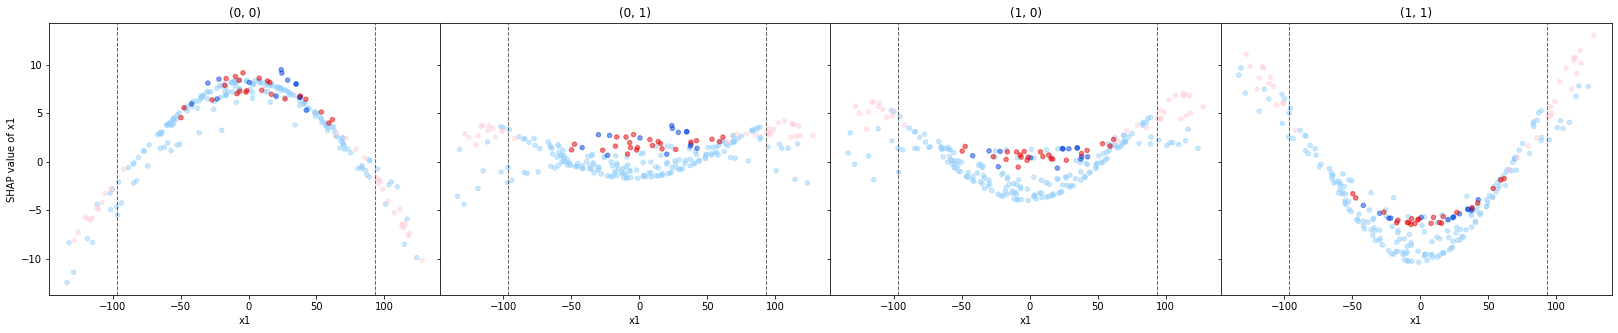

-129.7526473921083 <= x2 <= 128.64005345149593
[Lower CF: x2 == -131.2 --> {'(1, 1)': 55},
 Upper CF: x2 == 136.3 --> {'(1, 1)': 55}]


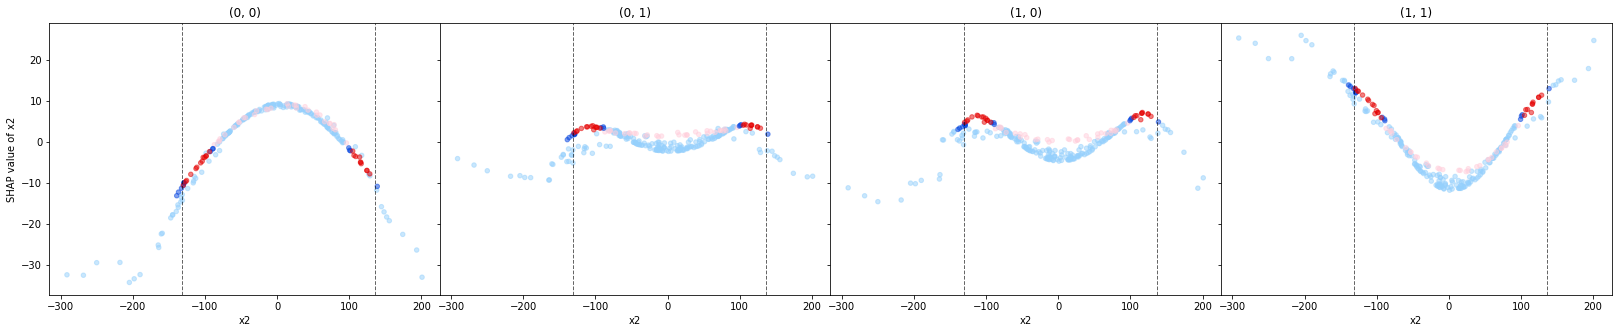

In [42]:
path[-1].plot_feature_dependence(*feature_names, focus=node, print_stats=True)

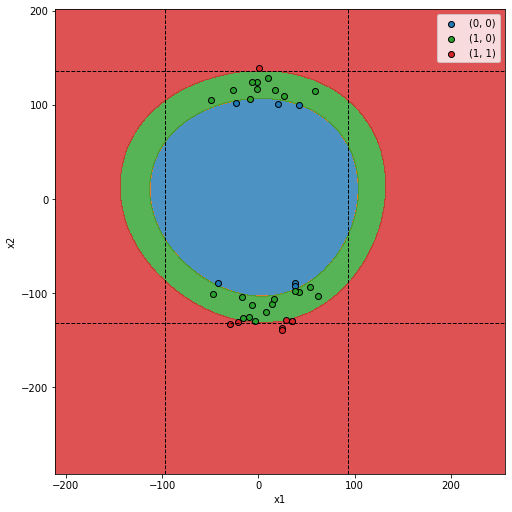

In [43]:
plot_2d_with_boundaries(node)

### Node 2.1

In [44]:
top = node.filter('x2 > 0')
node.class_counts

(1, 0)    23
(1, 1)     8
(0, 0)     6
dtype: int64

-49.65171317161805 <= x1 <= 61.6706946854942
[Lower CF: x1 == -96.6 --> {'(1, 1)': 23},
 Upper CF: x1 == 93.3 --> {'(1, 1)': 23}]


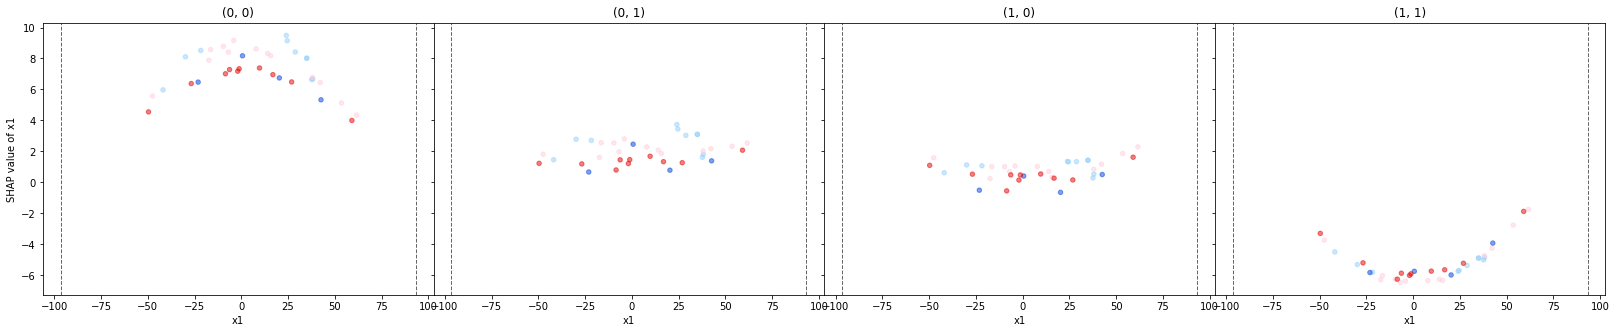

-129.7526473921083 <= x2 <= 128.64005345149593
[Lower CF: x2 == -131.2 --> {'(1, 1)': 23},
 Upper CF: x2 == 136.3 --> {'(1, 1)': 23}]


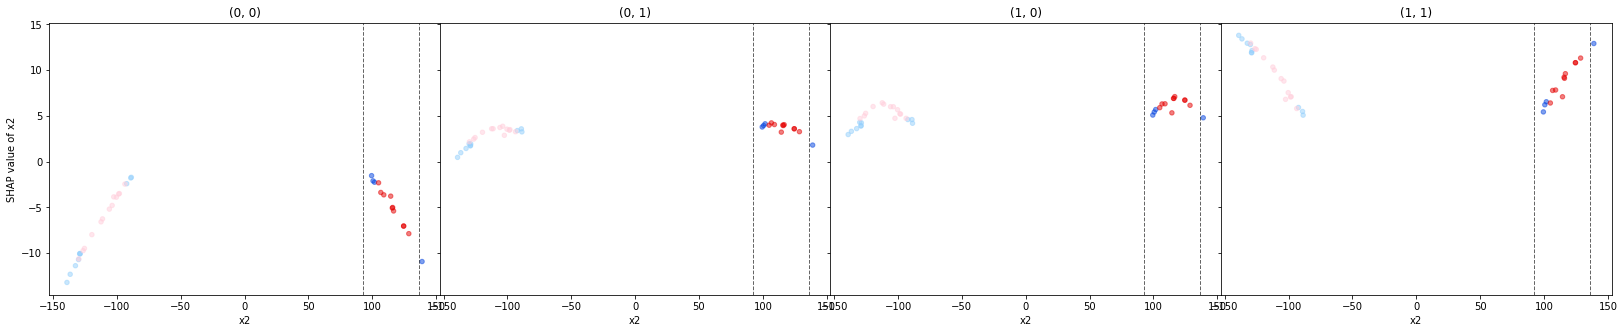

In [45]:
node.plot_feature_dependence(*feature_names, focus=top, print_stats=True)

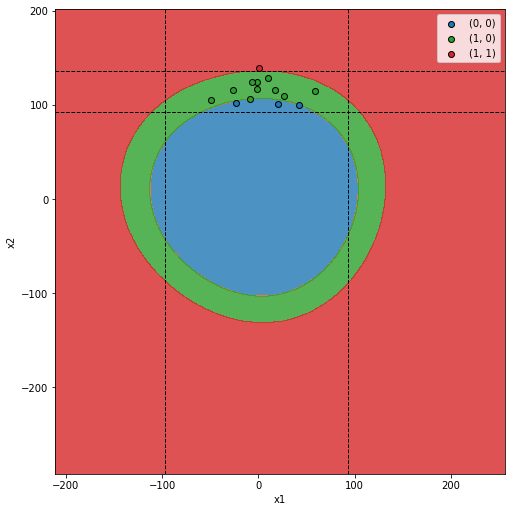

In [46]:
plot_2d_with_boundaries(top)

### Node 2.2

In [48]:
bottom = node.filter('x2 < 0')
node.class_counts

(1, 0)    23
(1, 1)     8
(0, 0)     6
dtype: int64

-49.65171317161805 <= x1 <= 61.6706946854942
[Lower CF: x1 == -96.6 --> {'(1, 1)': 23},
 Upper CF: x1 == 93.3 --> {'(1, 1)': 23}]


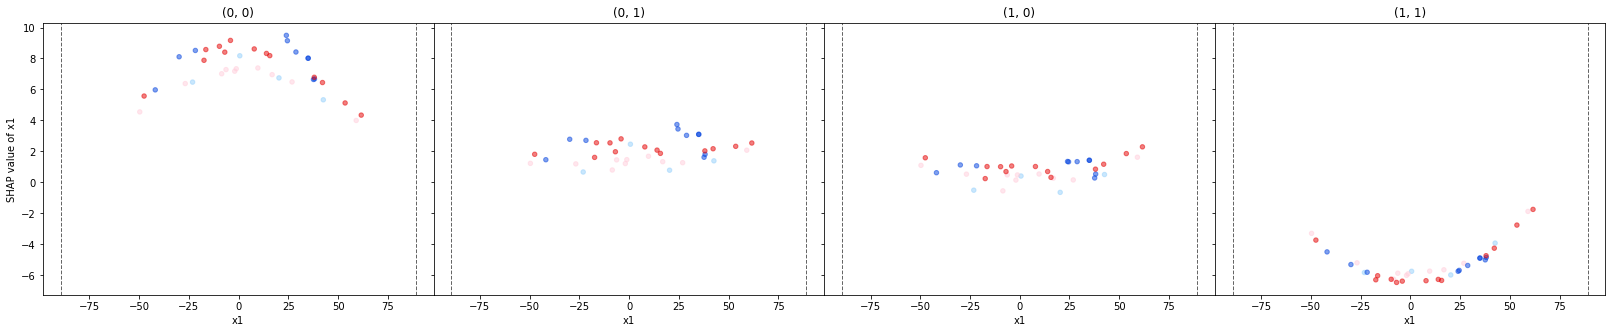

-129.7526473921083 <= x2 <= 128.64005345149593
[Lower CF: x2 == -131.2 --> {'(1, 1)': 23},
 Upper CF: x2 == 136.3 --> {'(1, 1)': 23}]


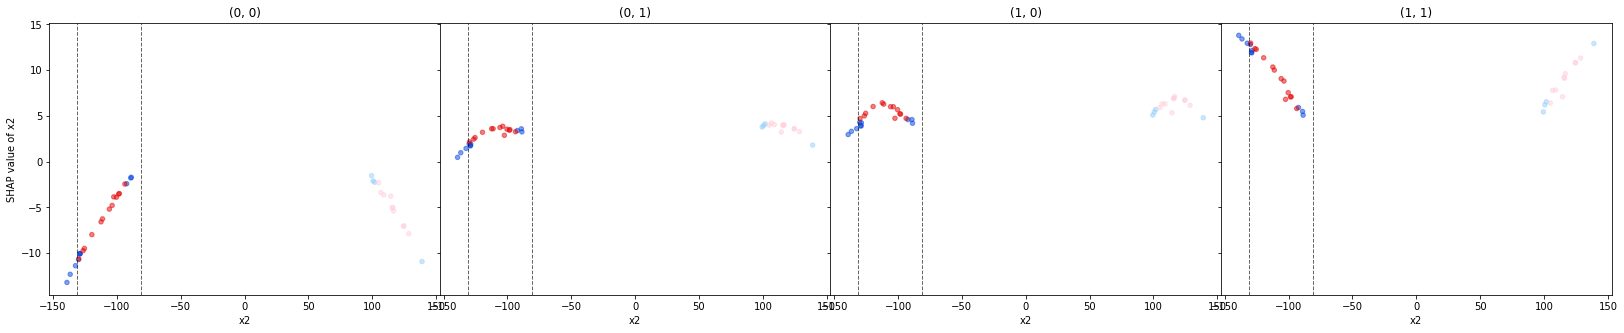

In [49]:
node.plot_feature_dependence(*feature_names, focus=bottom, print_stats=True)

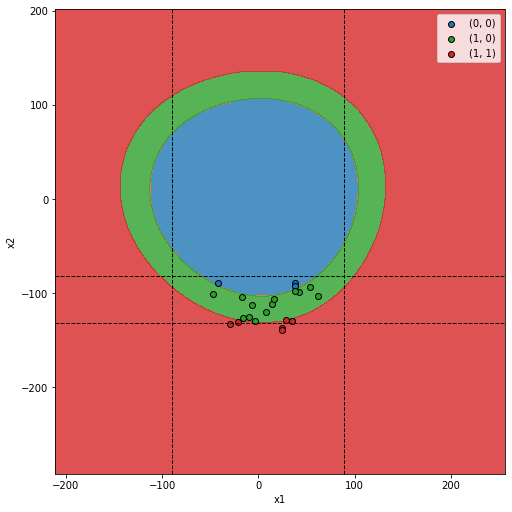

In [50]:
plot_2d_with_boundaries(bottom)

In [57]:
with open(f'manual-fix.pickle', 'wb') as f:
    pickle.dump([left, right, top, bottom], f)

# Evaluation

In [54]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

In [55]:
with open('test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [56]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('test.log_odds.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Exact explainer: 10001it [08:19, 19.77it/s]                          


CPU times: user 8min 1s, sys: 5.09 s, total: 8min 6s
Wall time: 8min 20s


In [58]:
with open('test.log_odds.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [59]:
explanations_per_class = {}
for class_name in comparer.class_names:
    explanations_per_class[class_name] = load(class_name)

In [60]:
metrics = eval_clusterings(explanations_per_class, X_test, y_test, shap_values_test, comparer.class_names)
metrics

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

,Precision,Recall,F1 Score,Support,Label,Nodes,Distance,Constraints
0,0.849245,1.000000,0.918478,4332.0,"(0, 0)",1,5281.429304,4
1,0.865573,0.998846,0.927446,4332.0,"(0, 0)",2,1885.917475,8
2,0.895859,0.998846,0.944554,4332.0,"(0, 0)",3,847.983847,12
3,0.928709,0.998384,0.962287,4332.0,"(0, 0)",4,575.764306,16
4,0.928709,0.998384,0.962287,4332.0,"(0, 0)",5,206.512484,20
...,...,...,...,...,...,...,...,...
190,0.970517,0.399950,0.566462,4033.0,"(1, 1)",58,0.614539,54
191,0.970746,0.403174,0.569727,4033.0,"(1, 1)",59,0.519352,55
192,0.970746,0.403174,0.569727,4033.0,"(1, 1)",60,0.302615,56
193,0.971890,0.402926,0.569676,4033.0,"(1, 1)",61,0.003754,58


In [61]:
grouped_metrics, constraints = group_metrics(metrics, by='Distance', direction='down')

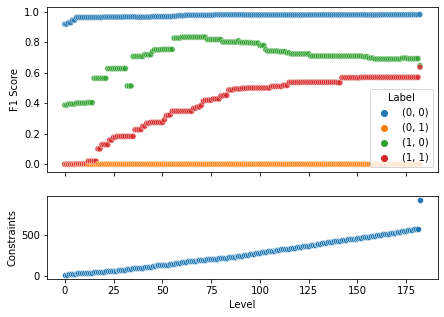

In [63]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('gaussian-shap-fidelity.pdf')

In [64]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes     Distance  \
Level                                                                         
0     0  (0, 0)   0.849245  1.000000  0.918478   4332.0    1.0  5281.429304   
      1  (0, 1)   0.000000  0.000000  0.000000      0.0    1.0  5281.429304   
      2  (1, 0)   0.240400  0.999388  0.387571   1635.0    1.0  5281.429304   
      3  (1, 1)   0.000000  0.000000  0.000000   4033.0    1.0  5281.429304   
1     0  (0, 0)   0.849245  1.000000  0.918478   4332.0    1.0  5281.429304   
...         ...        ...       ...       ...      ...    ...          ...   
181   3  (1, 1)   0.971890  0.402926  0.569676   4033.0   61.0     0.003754   
182   0  (0, 0)   0.993849  0.969760  0.981657   4332.0  150.0     0.000000   
      1  (0, 1)   0.000000  0.000000  0.000000      0.0    1.0  5281.429304   
      2  (1, 0)   0.882540  0.510092  0.646512   1635.0   55.0     0.000000   
      3  (1, 1)   0.987493  0.469874  0.636761   4033.0   95.0     0.000000   

         Constraints  
Level                 
0     0          4.0  
      1          0.0  
      2          4.0  
      3          0.0  
1     0          4.0  
...              ...  
181   3         58.0  
182   0        600.0  
      1          0.0  
      2        220.0  
      3        111.0  

[732 rows x 8 columns]

In [63]:
constraints

Level
0       8.0
1      10.0
2      11.0
3      16.0
4      18.0
      ...  
87    189.0
88    190.0
89    192.0
90    194.0
91    297.0
Name: Constraints, Length: 92, dtype: float64

with manual fix:

In [65]:
with open(f'manual-fix.pickle', 'rb') as f:
    nodes = pickle.load(f)

In [67]:
eval_clusterings_for_class('(1, 0)', nodes, X_test, y_test, shap_values_test)

Precision      0.451163
Recall         0.652599
F1 Score         0.5335
Support          1635.0
Label            (1, 0)
Nodes                 4
Constraints          16
Name: True, dtype: object